## VGG16 binary image classification with TensorFlow 2.10

In [1]:
#Turn off GPU inference
import os
os.environ["CUDA_VISIBLE_DEVICES"]="-1"

In [2]:
from scipy.linalg import toeplitz
import pandas as pd
import numpy as np
import joblib

#pd.set_option('max_colwidth', 2000)
pd.options.display.max_rows = 500
pd.options.display.max_columns = 500

from IPython.display import display, Math
import matplotlib.pyplot as plt
import seaborn as sns

import tensorflow as tf
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import numpy as np
from scipy.signal import find_peaks

tf.config.list_physical_devices()

[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU')]

In [3]:
#!pip freeze > requirements.txt

In [4]:
#Print selected library versions
print('tensorflow:', tf.__version__)
print('pandas:', pd.__version__)
print('numpy:', np.__version__)
print('joblib:', joblib.__version__)

tensorflow: 2.10.0
pandas: 1.4.4
numpy: 1.23.3
joblib: 1.1.0


### Load dataframe with data from joblib

In [5]:
df = joblib.load('signals.joblib')
df.tail(3)

,nc1,lc1,dc1
799998,0.653171,-0.637368,0.240326
799999,0.047256,0.204431,0.319485
800000,-0.682212,0.365421,0.589967


In [6]:
df.describe().round(2)

,nc1,lc1,dc1
count,800001.00,800001.00,800001.00
mean,0.00,-0.00,-0.00
std,0.61,0.65,0.78
min,-2.83,-5.93,-29.33
25%,-0.48,-0.47,-0.49
50%,0.07,0.06,0.03
75%,0.51,0.50,0.50
max,2.69,6.18,26.15


### Helper Functions

In [7]:
def kernel_density(x, dist_samples=500):    
    '''Univariate KDE of x with scotts_factor for bandwidth.  Returns
    PDF for the specified number of samples in the range of x.'''
    
    from sklearn.neighbors import KernelDensity
    b_width = len(x)**(-1/5)
    x_grid = np.linspace(x.min(), x.max(), dist_samples)    
    kde_model = KernelDensity(bandwidth=b_width)
    kde_model.fit(x[:, np.newaxis])
    y_kde = np.exp(kde_model.score_samples(x_grid[:, np.newaxis]))
    return x_grid, y_kde

In [8]:
def get_signal_window(feature_ser: pd.Series, num_points: int, start_index: int):
    '''Input is signal.  Returns signal segment as 1-D np.array.  Also returns start
    and end indices.'''
    end_index = start_index + num_points
    return feature_ser.iloc[start_index : end_index].values, start_index, end_index

In [9]:
def plot_time_signal(signal: np.array, Hz: float, title: str):
    '''Plot signal.'''
    seconds = np.linspace(start=0.0, stop=len(signal)/Hz, num=len(signal)) # seconds = len(signal)/Hz
    fig, (ax1) = plt.subplots(1,1, figsize=(16,4))
    ax1.plot(seconds, signal, c='black', linewidth=0.5, marker = '.') 
    plt.grid( axis='y')
    ax1.set_title(f'{title} signal - {len(signal)} points over {np.round(len(seconds)/Hz,2)} sec', fontsize=16); 
    ax1.set_xlabel('seconds', fontsize=14); 
    ax1.set_ylabel('amplitude', fontsize=14); 
    ax1.set_xlim(xmin=0);ax1.set_ylim(-2,2)       
    plt.show() 

### Visualize

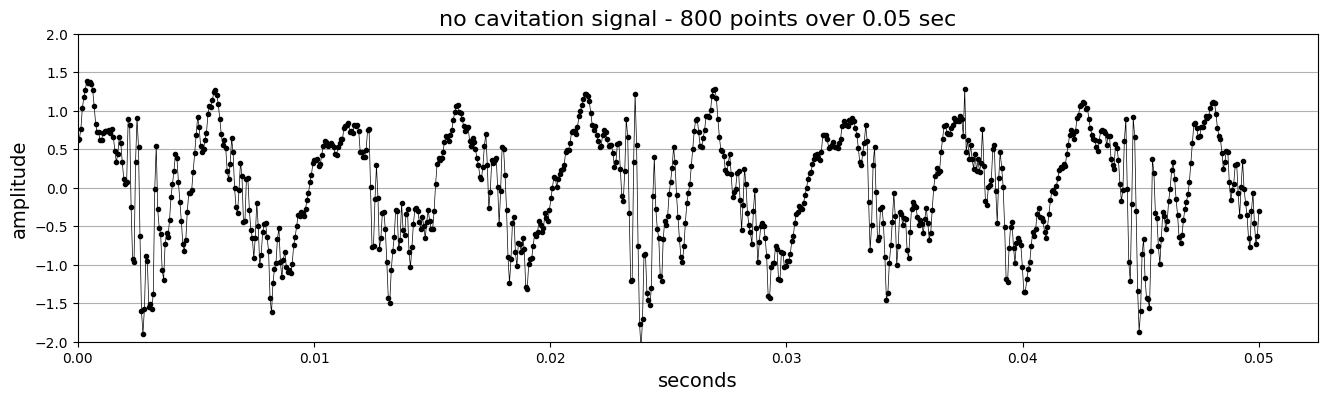

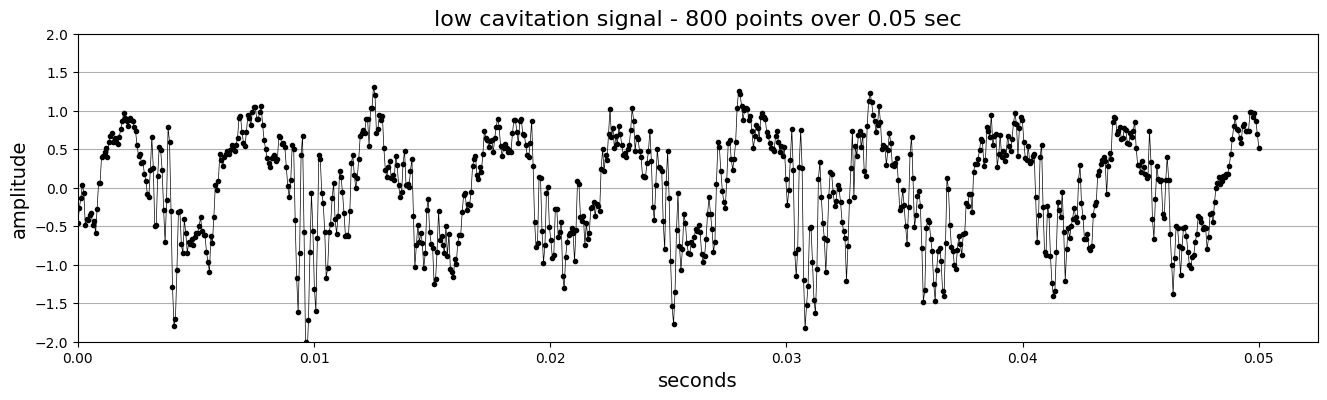

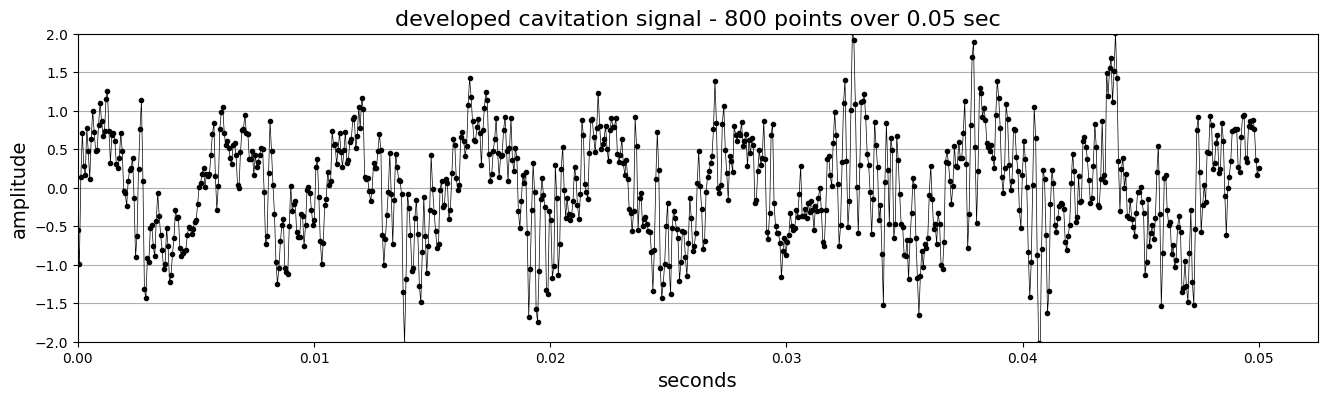

In [10]:
sig1, start_idx, end_idx = get_signal_window(feature_ser=df['nc1'], num_points=800, start_index=140500) 
plot_time_signal(signal=sig1, Hz=16_000, title='no cavitation')
sig1, start_idx, end_idx = get_signal_window(feature_ser=df['lc1'], num_points=800, start_index=140500) 
plot_time_signal(signal=sig1, Hz=16_000, title='low cavitation')
sig1, start_idx, end_idx = get_signal_window(feature_ser=df['dc1'], num_points=800, start_index=140500) 
plot_time_signal(signal=sig1, Hz=16_000, title='developed cavitation')

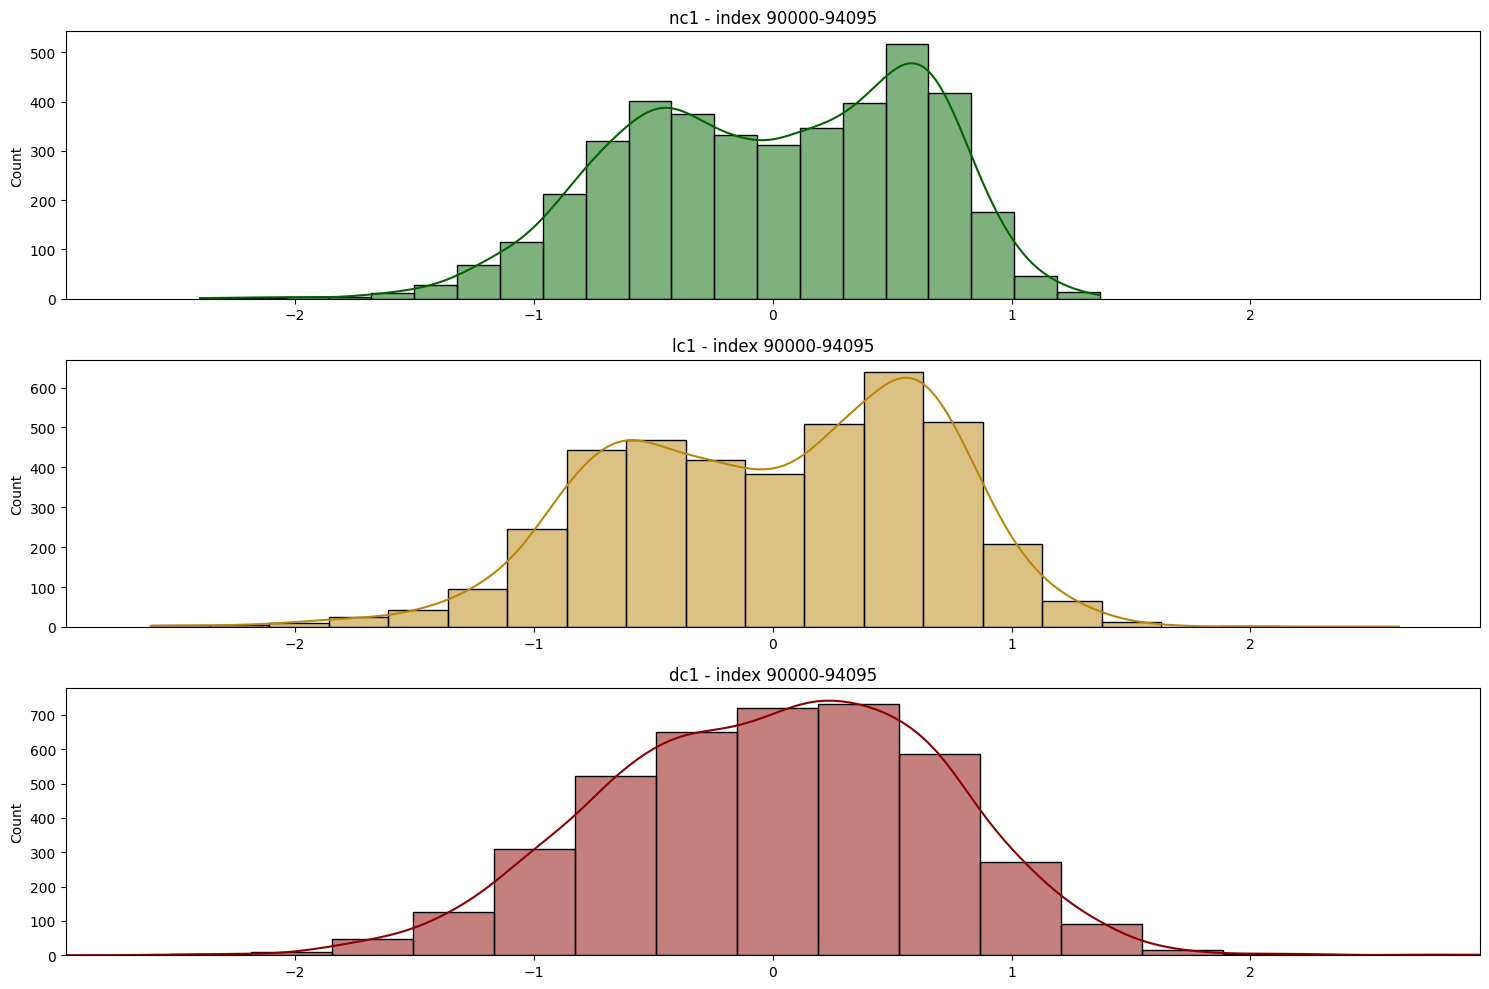

In [11]:
#Histplot the features
nc1w, start_idx, end_idx = get_signal_window(feature_ser=df['nc1'], num_points=2**12-1, start_index=90000)
lc1w, start_idx, end_idx = get_signal_window(feature_ser=df['lc1'], num_points=2**12-1, start_index=90000)
dc1w, start_idx, end_idx = get_signal_window(feature_ser=df['dc1'], num_points=2**12-1, start_index=90000)

lims = (np.std(nc1w) * 3 +  np.std(lc1w) * 3 + np.std(dc1w) * 3) / 2 # Three-sigma average of the two classes, nc1 and dc1
n_bins = int(np.sqrt(len(nc1w))/3)

fig, (ax1, ax2, ax3) = plt.subplots(3,1, figsize = (15,10))
ax1.set_xlim(-lims, lims); ax2.set_xlim(-lims, lims); ax3.set_xlim(-lims, lims);
ax1.axis('on'); ax2.axis('on');
ax1.set_title(f'nc1 - index {start_idx}-{end_idx}'); 
ax2.set_title(f'lc1 - index {start_idx}-{end_idx}');
ax3.set_title(f'dc1 - index {start_idx}-{end_idx}');

sns.histplot(nc1w, element='bars', ax=ax1, color='darkgreen', bins=n_bins, kde=True)
sns.histplot(lc1w, element='bars', ax=ax2, color='darkgoldenrod', bins=n_bins, kde=True)
sns.histplot(dc1w, element='bars', ax=ax3, color='darkred', bins=n_bins, kde=True)
plt.tight_layout()

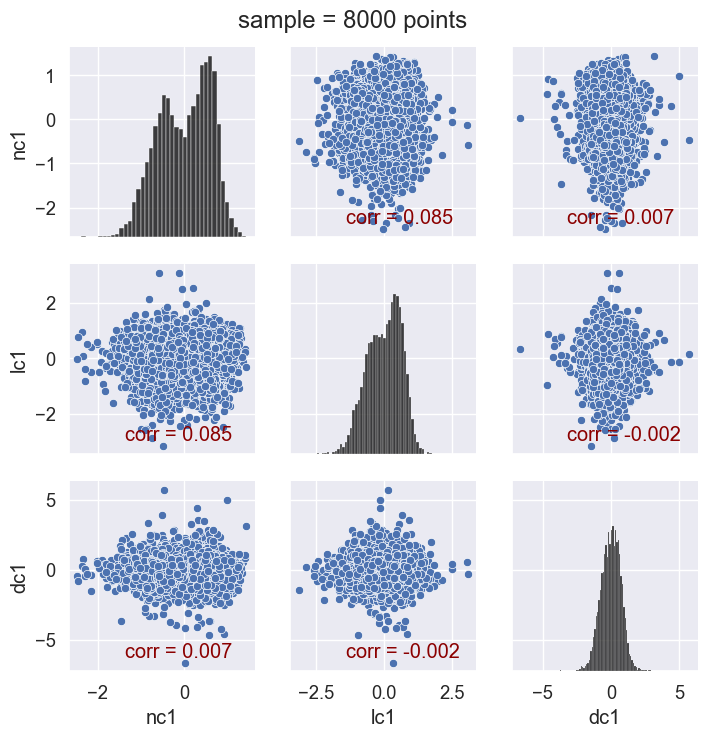

In [12]:
samp = df.sample(frac=0.01, replace=False)   
samp.shape

def annotate_w_xy_corr(x, y, **kwargs):
    coef = np.corrcoef(x, y)[0][1]
    label = r'corr = ' + str(round(coef,3))
    ax = plt.gca()
    ax.annotate(label, xy = (0.3, .07), xycoords = ax.transAxes, c='darkred') #size = 18

def pairplot_w_corr(df : pd.DataFrame):        
        
    sns.set(font_scale=1.2)
    g = sns.PairGrid(df)
    g.fig.subplots_adjust(top=0.93)
    g.fig.suptitle(f'sample = {len(df)} points')
    g.map_upper(sns.scatterplot)
    g.map_upper(annotate_w_xy_corr)
    g.map_lower(sns.scatterplot)
    g.map_lower(annotate_w_xy_corr)
    g.map_diag(sns.histplot, color='black')
    
pairplot_w_corr(df=samp)

# Model with Tensorflow 2

Found 330 files belonging to 2 classes.
Using 264 files for training.
Found 330 files belonging to 2 classes.
Using 66 files for validation.


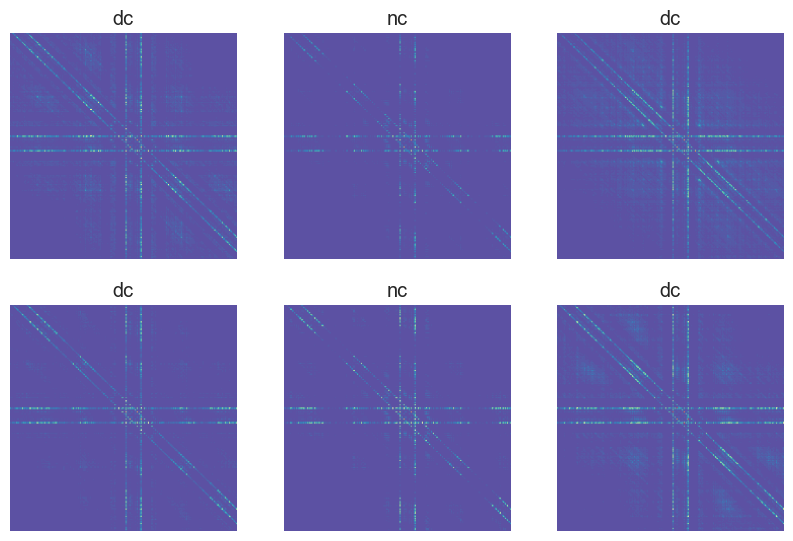

In [13]:
from keras.applications.vgg16 import VGG16
from tensorflow.keras.applications.vgg16 import preprocess_input

#Create dataset.  The file_paths method shows train_ds and val_ds are mutually exclusive.
train_ds = tf.keras.utils.image_dataset_from_directory(
  './images/train',
  labels='inferred',
  validation_split=0.2,
  subset="training",
  seed=5,
  image_size=(224, 224),
  batch_size=30)

val_ds = tf.keras.utils.image_dataset_from_directory(
  './images/train',
  labels='inferred',
  validation_split=0.2,
  subset="validation",
  seed=5,
  image_size=(224, 224),
  batch_size=30)

class_names = train_ds.class_names
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
    for i in range(6):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))  #uint is 0 to 255.
        plt.title(class_names[labels[i]]); plt.axis("off");

In [14]:
#Class names and shapes
print('1 train class names:', train_ds.class_names)
print('2 val class names:', val_ds.class_names)

for image_batch, labels_batch in train_ds:
    print('3 images, xpixels, ypixels, color_channels:',image_batch.shape)
    print('4 labels:', labels_batch.shape)
    break

1 train class names: ['dc', 'nc']
2 val class names: ['dc', 'nc']
3 images, xpixels, ypixels, color_channels: (30, 224, 224, 3)
4 labels: (30,)


In [15]:
#Preprocess dataset per https://www.tensorflow.org/tutorials/load_data/images
train_ds = train_ds.map(lambda x, y: (preprocess_input(x), y))  #num_parallel_calls can lift perf. in some cases
val_ds = val_ds.map(lambda x, y: (preprocess_input(x), y))

# Show min/max of first image. Notice the pixel values after preprocess.
image_batch, labels_batch = next(iter(train_ds))
first_image = image_batch[0]
print('image min and max values:', np.min(first_image), np.max(first_image), '\n\n')

# Load and freeze VGG16 model.
# Include_top=False removes classification layer trained on ImageNet.
base_model = VGG16(weights="imagenet", include_top=False, input_shape=(224,224,3))
base_model.trainable = False ## Not trainable weights
base_model.summary()

image min and max values: -72.68 130.32 


Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxP

In [16]:
#Add classification layers.
from tensorflow.keras import layers, models

flatten_layer = layers.Flatten()
dense_layer_1 = layers.Dense(80, activation='relu')
dense_layer_2 = layers.Dense(20, activation='relu')
prediction_layer = layers.Dense(1, activation='sigmoid') #sigmoid for binary activation

#Transfer learning - base_model plus classifcation layers.
model = models.Sequential([
    base_model,
    flatten_layer,
    dense_layer_1,
    dense_layer_2,
    prediction_layer,
])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 7, 7, 512)         14714688  
                                                                 
 flatten (Flatten)           (None, 25088)             0         
                                                                 
 dense (Dense)               (None, 80)                2007120   
                                                                 
 dense_1 (Dense)             (None, 20)                1620      
                                                                 
 dense_2 (Dense)             (None, 1)                 21        
                                                                 
Total params: 16,723,449
Trainable params: 2,008,761
Non-trainable params: 14,714,688
_________________________________________________________________


In [17]:
# Verify number of parameters in Layer = 'dense' makes sense.  25088*80 + 80 = 2,007,120.
model.get_layer('dense_1').get_weights()[0].shape

(80, 20)

### Train and Measure

In [18]:
#Train model and get metrics. 
model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy'],    
)

from keras.callbacks import Callback
class Histories(Callback):
    
    def on_train_begin(self,logs={}):
        self.batch_loss = []
        self.batch_accuracy = []
        self.loss = []
        self.accuracy = []
        self.val_loss = []
        self.val_accuracy = []
    
    def on_train_batch_end(self, batch, logs={}):
        self.batch_loss.append(logs.get('loss'))
        self.batch_accuracy.append(logs.get('accuracy'))               
        
    def on_epoch_end(self, epoch, logs={}):
        self.loss.append(logs.get('loss'))
        self.accuracy.append(logs.get('accuracy'))
        self.val_loss.append(logs.get('val_loss'))
        self.val_accuracy.append(logs.get('val_accuracy'))

histories = Histories()

#Fit model in 3 epochs.  Save metrics to history.
history = model.fit(train_ds, validation_data=val_ds, epochs=3, callbacks=[histories])

#Load test dataset for predictions.
test_ds = tf.keras.utils.image_dataset_from_directory(
  './images/test',
  labels='inferred',
  seed=None,
  image_size=(224, 224),
  batch_size=30)
test_ds = test_ds.map(lambda x, y: (preprocess_input(x), y))

predictions = model.predict(test_ds)
predictions = tf.where(predictions < 0.5,0, 1).numpy()
print('\nPredictions:\n', predictions.T, '\n')

Epoch 1/3
9/9 [==============================] - 11s 1s/step - loss: 1.8980 - accuracy: 0.8447 - val_loss: 5.8334e-12 - val_accuracy: 1.0000
Epoch 2/3
9/9 [==============================] - 10s 1s/step - loss: 3.3227e-05 - accuracy: 1.0000 - val_loss: 2.1212e-13 - val_accuracy: 1.0000
Epoch 3/3
9/9 [==============================] - 10s 1s/step - loss: 1.8069e-13 - accuracy: 1.0000 - val_loss: 2.8639e-13 - val_accuracy: 1.0000
Found 60 files belonging to 2 classes.
2/2 [==============================] - 2s 902ms/step

Predictions:
 [[0 0 0 0 0 0 1 0 1 0 1 0 1 1 0 1 1 0 0 0 1 1 1 1 0 0 1 0 1 1 0 0 0 1 1 0
  0 1 1 0 1 0 1 0 1 1 1 0 1 1 0 1 0 0 1 0 1 1 0 1]] 



### Loass and Accuracy

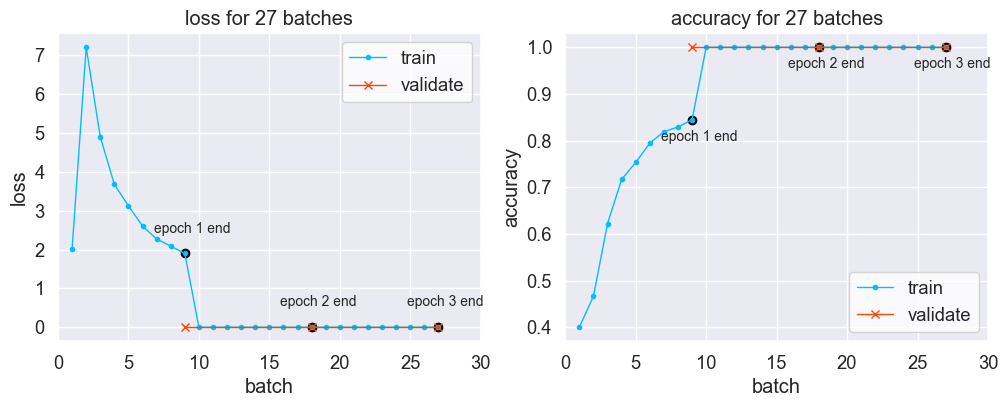

In [19]:
#Accuracy by batch and epoch
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(12,4))
sns.set_style("whitegrid")
cnt_allbatches = len(histories.batch_accuracy)
cnt_allepochs = len(histories.accuracy)
batch_x = range(1, len(histories.batch_accuracy)+1)
batch_acc = histories.batch_accuracy
batch_loss = histories.batch_loss

epoch_x = range(cnt_allbatches//cnt_allepochs, cnt_allbatches + 1, cnt_allbatches//cnt_allepochs)
epoch_acc = histories.accuracy
epoch_loss = histories.loss
val_acc = histories.val_accuracy
val_loss = histories.val_loss

ax1.plot(batch_x, batch_loss, c='deepskyblue', linewidth=1, marker='.')
ax1.plot(epoch_x, val_loss, c='orangered', linewidth=1, marker='x')
ax1.scatter(epoch_x, epoch_loss, c='black', marker='o')

ax1.set_title(f'loss for {len(batch_loss)} batches');
ax1.set_xlabel('batch'); ax1.set_ylabel('loss') 
ax1.set_xlim(0, len(batch_x)+3)
ax1.legend(['train','validate'])

for a, b in zip(epoch_x, epoch_loss):
    ax1.annotate(f'epoch {a//9} end', # this is the text
                 (a, b), # these are the coordinates to position the label
                 textcoords='offset points',
                 xytext=(5,15),
                 size = 10,
                 ha='center') # horizontal alignment can be left, right or center

ax2.plot(batch_x, batch_acc, c='deepskyblue', linewidth=1, marker='.')
ax2.plot(epoch_x, val_acc, c='orangered', linewidth=1, marker='x')

ax2.scatter(epoch_x, epoch_acc, c='black', marker='o')
ax2.set_title(f'accuracy for {len(batch_acc)} batches');
ax2.set_xlabel('batch'); ax2.set_ylabel('accuracy') 
ax2.set_xlim(0, len(batch_x)+3)
ax2.legend(['train','validate'])

for a, b in zip(epoch_x, epoch_acc):
    ax2.annotate(f'epoch {a//9} end', # this is the text
                 (a, b), # these are the coordinates to position the label
                 textcoords='offset points',
                 xytext=(5,-15),
                 size = 10,
                 ha='center') # horizontal alignment can be left, right or center    

## Evaluate test_ds

In [20]:
#Evaluate model accuracy on test data: test_ds.  Accuracy should be at or near 100 percent (accuracy: 1.0000).
model.evaluate(test_ds)

2/2 [==============================] - 2s 916ms/step - loss: 5.2229e-14 - accuracy: 1.0000


[5.2229379675361454e-14, 1.0]

### Quick Peak Counting Example

In [40]:
#Initialize variables.
num_pts = 8000
step_size = 8000  #try step_size 1000 to test 800 segments per feature.
features = ['nc1', 'dc1']
start_idx_grid = range(0, (len(df) - num_pts + 1), step_size)
nc1_error_cnt=0
dc1_error_cnt=0

#Iterate through segments of features.  Segments have num_pts.
for start_idx in start_idx_grid:
    for feat in features:
        end_idx = start_idx + num_pts    
        segment = df[feat].iloc[start_idx:end_idx].values
        x, y_kde = kernel_density(segment, dist_samples=200)
        peaks_num = len(find_peaks(y_kde, height=0.2, distance=None)[0])
        if feat == 'nc1' and peaks_num != 2:
            print(f'Error detail: {feat} indices {start_idx}-{end_idx} | peaks_num:', peaks_num)
            nc1_error_cnt+=1
        if feat == 'dc1' and peaks_num != 1:
            print(f'Error detail: {feat} indices {start_idx}-{end_idx} | peaks_num:', peaks_num)
            dc1_error_cnt+=1

#Summary of errors.
accuracy = round(((len(df)/step_size*2) - (nc1_error_cnt+dc1_error_cnt))/(len(df)/step_size*2)*100,3)
print(f'\n\nTOTAL ERRORS PER FEATURE (step size={step_size}):')
print('--------------------------------------------')
print('nc1 - peaks not equal to 2:', nc1_error_cnt)
print('dc1 - peaks not equal to 1:', dc1_error_cnt,'\n')
print('Overall accuracy:', accuracy, 'percent')

Error detail: nc1 indices 200000-208000 | peaks_num: 1


TOTAL ERRORS PER FEATURE (step size=8000):
--------------------------------------------
nc1 - peaks not equal to 2: 1
dc1 - peaks not equal to 1: 0 

Overall accuracy: 99.5 percent


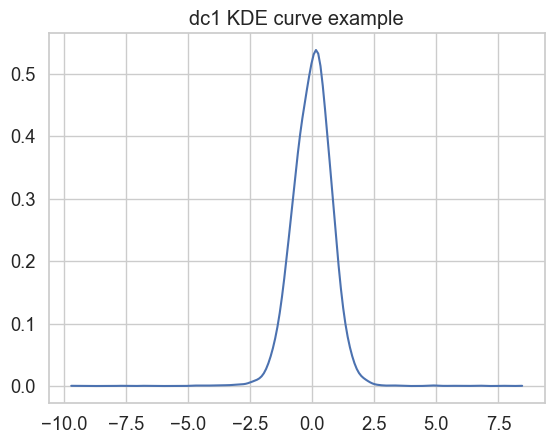

In [41]:
#Show last KDE curve.
plt.plot(x, y_kde)
plt.title(f'{feat} KDE curve example')
plt.show()